In [1]:
import trace.tracepol as tp
import numpy as np
from astropy.io import fits
import itsosspipeline as soss
import sys
import os
import specgen.spgen as spgen
from sys import path

# Imports for plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # For displaying of FITS images.
%matplotlib notebook

import box_kim

In [2]:
# Matplotlib defaults
plt.rc('figure', figsize=(8,4.5))
plt.rc('font', size=12)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=1)

In [3]:
WORKING_DIR = '/home/kmorel/ongenesis/jwst-user-soss/PHY3030/'

sys.path.insert(0, "/genesis/jwst/jwst-ref-soss/fortran_lib/")

# Read in all paths used to locate reference files and directories
config_paths_filename = os.path.join(WORKING_DIR, 'jwst-mtl_configpath_kim.txt')
pathPars = soss.paths()
soss.readpaths(config_paths_filename, pathPars)

# Create and read the simulation parameters
simuPars = spgen.ModelPars()              # Set up default parameters
simuPars = spgen.read_pars(pathPars.simulationparamfile, simuPars)    # Read in parameter file

spgen.py - warning - fix the bug with orderlist


In [4]:
gain = 1.61   #[é]

def normalization(f_lambda, t1, t4):
    """
    Normalize transit light curve by mean during out of transit.
    """
    hors_t = np.concatenate((f_lambda[: t1 + 1], f_lambda[t4:]))
    mean = np.mean(hors_t)
    return f_lambda / mean

def transit_depth(f_lambda, t2, t3):
    """
    Calculates mean flux value during transit.
    """
    return np.mean(f_lambda[t2: t3+1])

def no_dms_simulation(file_name, gain=gain):
    with fits.open(WORKING_DIR + file_name) as hdulist:
        ng = hdulist[0].header['NGROUPS']      #n_groups
        t_read = hdulist[0].header['TGROUP']   # Reading time [s]
        tint = (ng - 1) * t_read               # Integration time [s]
        
        simu = hdulist
        data = (hdulist[1].data[:,-1] - hdulist[1].data[:,0]) / tint / gain   # Images of flux [adu/s]
    return simu, data

def rateints_dms_simulation(file_name):
    with fits.open(WORKING_DIR + file_name) as hdulist:
        data_noisy_rateints = hdulist[1].data     # Images of flux [adu/s]
        #delta_noisy = hdulist[2].data            # Errors [adu/s]
        dq = hdulist[3].data                      # Data quality
        i = np.where(dq % 2 != 0)  # Odd values of dq = DO NOT USE these pixels
        data_noisy_rateints[i[0], i[1], i[2]] = 0.
        #delta_noisy[i[0], i[1], i[2]] = 0.
        
        simu = hdulist
        data = data_noisy_rateints
    return simu, data, i

Load simulations

In [19]:
# CHOOSE simulations to use/compare: CHANGE True's and False's
# CHANGE 1 and 2 values for data variable also!!!
if False:   # Photon noise, no DMS
    simu_0, data_0 = no_dms_simulation('IDTSOSS_clear_noisy--photon.fits')
    simulation_0 = 'Photon noise, no DMS'
    
if False:   # Photon noise, after DMS
    simu_0, data_0, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noisy--photon_rateints.fits')
    simulation_0 = 'Photon noise, after DMS'
    
if False:   # Superbias noise, no DMS
    simu_0, data_0 = no_dms_simulation('IDTSOSS_clear_noisy--superbias.fits')
    simulation_0 = 'Superbias noise, no DMS'
    
if False:   # Superbias noise, after DMS
    simu_0, data_0, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noisy--superbias_rateints.fits')
    simulation_0 = 'Superbias noise, after DMS'
    
if False:   # Nonlinearity noise, after DMS
    simu_0, data_0, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noisy--nonlinearity_rateints.fits')
    simulation_0 = 'Nonlinearity noise, after DMS'
    
if True:   # Photon, superbias and nonlinearity noises, after DMS
    simu_2, data_2, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noisy--photon--nonlinearity--superbias_rateints.fits')
    simulation_2 = 'Photon, nonlinearity and superbias noises, after DMS'
    
if False:   # Photon and superbias noises, after DMS
    simu_0, data_0, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noisy--photon--superbias_rateints.fits')
    simulation_0 = 'Photon and superbias noises, after DMS'

if True:   # Noiseless, no DMS
    simu_1, data_1 = no_dms_simulation('IDTSOSS_clear.fits')
    simulation_1 = 'Noiseless, no DMS' 
    #data_0[bad_ind[0], bad_ind[1], bad_ind[2]] = 0. # I put bad pixels to 0 here too
    
if False:   # Noiseless, after DMS
    simu_0, data_0, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noNoise_rateints.fits')
    simulation_0 = 'Noiseless, after DMS'
    
# Convert data from fits files to float (fits precision is 1e-8)
data_1 = data_1.astype('float64', copy=False)
data_2 = data_2.astype('float64', copy=False)
#delta_noisy = delta_noisy.astype('float64', copy=False)

print('Simulation 1:', simulation_1)
print('Simulation 2:', simulation_2)

Simulation 1: Noiseless, no DMS
Simulation 2: Photon, nonlinearity and superbias noises, after DMS


In [6]:
# difference = data_2-data_1
# plt.figure()
# plt.hist(np.ndarray.flatten(difference[10]), bins=50, range=(-1, 1))
# plt.show()

Extraction

In [20]:
# BOX EXTRACTION
radius_pixel = 30  # Radius for box extraction

# Position of trace for box extraction
x, y, w = box_kim.readtrace(os=1)

# Extractions
fbox_1 = np.zeros(shape=(np.shape(data_1)[0], np.shape(data_1)[2]), dtype=float)
fbox_2 = np.zeros(shape=(np.shape(data_2)[0], np.shape(data_2)[2]), dtype=float)

oversample = simuPars.noversample  # Oversampling of the simulation

for t in range(np.shape(data_1)[0]):  # For each image of the timeseries
    fbox_1[t] = box_kim.flambda_adu(x, data_1[t], y, radius_pixel=radius_pixel) #/ oversample   # [adu/s]
    fbox_2[t] = box_kim.flambda_adu(x, data_2[t], y, radius_pixel=radius_pixel) #/ oversample   # [adu/s]

In [21]:
t1 = 95   # * tint / 60  # [min]
t2 = 155   # * tint / 60  # [min]
t3 = 283   # * tint / 60  # [min]
t4 = 343   # * tint / 60  # [min]

ng = simu_1[0].header['NGROUPS']      #n_groups
t_read = simu_1[0].header['TGROUP']   # Reading time [s]
tint = (ng - 1) * t_read               # Integration time [s]
        
lam_array = w   # Wavelengths array

f_array_1 = np.nan_to_num(fbox_1)
f_array_2 = np.nan_to_num(fbox_2)

time = np.arange(f_array_1.shape[0])
time_min = time * tint / 60.  # [min]
time_fit = np.concatenate((time[:t1], time[t4:]))

White light curves

In [22]:
# Sum all detector
f_white_1_sum = np.sum(data_1, axis=(1, 2))
f_white_2_sum = np.sum(data_2, axis=(1, 2))

# White light curve
f_white_1 = np.sum(f_array_1, axis=1)
f_white_2 = np.sum(f_array_2, axis=1)

# Normalize white light curve
f_white_1_norm = normalization(f_white_1, t1, t4)
f_white_2_norm = normalization(f_white_2, t1, t4)

In [23]:
# For each wavelength
f_array_1_norm = np.copy(f_array_1)
f_array_2_norm = np.copy(f_array_2)

mean_t2t3_1 = np.zeros_like(w, dtype='float')
mean_t2t3_2= np.zeros_like(w, dtype='float')

for n in range(f_array_1.shape[1]):   # For each wavelength
    f_array_1_norm[:, n] = normalization(f_array_1[:, n], t1, t4)
    f_array_2_norm[:, n] = normalization(f_array_2[:, n], t1, t4)
    mean_t2t3_1[n] = transit_depth(f_array_1[:, n], t2, t3)
    mean_t2t3_2[n] = transit_depth(f_array_2[:, n], t2, t3)

<ipython-input-4-d150ab263e49>:9: RuntimeWarning: invalid value encountered in true_divide
  return f_lambda / mean


<IPython.core.display.Javascript object>


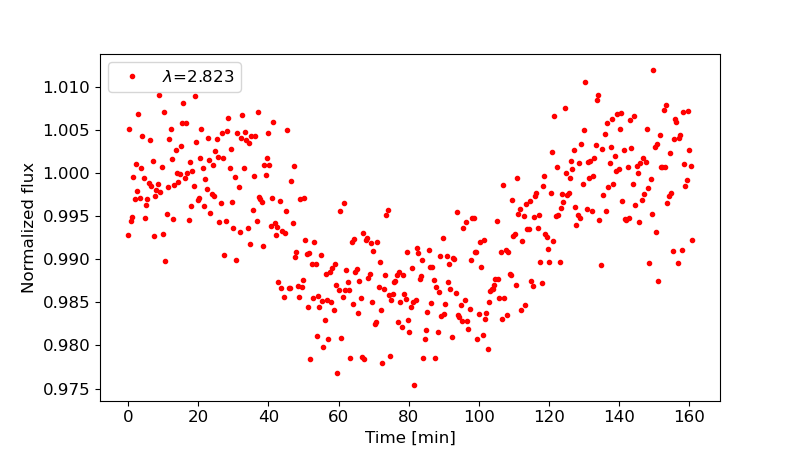

In [24]:
# Plot transit curve for particular wavelengths
# Choose indice
l = 10

plt.figure()
plt.plot(time_min, f_array_2_norm[:,l], '.', color='r', label=r'$\lambda$={:.3f}'.format(w[l]))
plt.xlabel('Time [min]')
plt.ylabel(r'Normalized flux')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


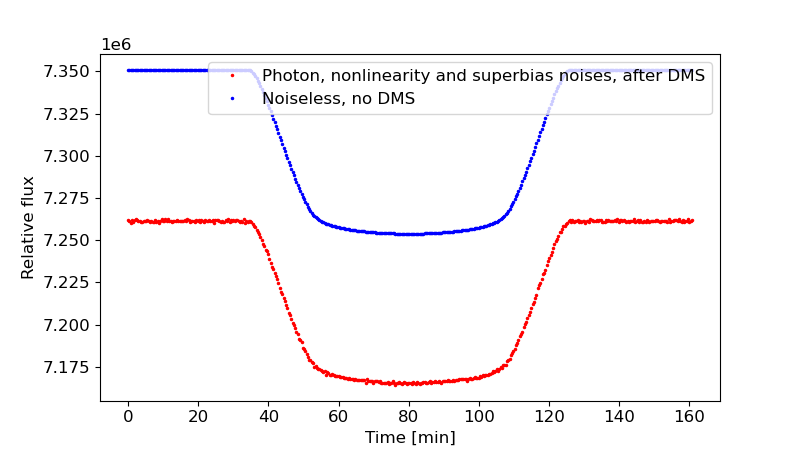

In [25]:
plt.figure()
plt.plot(time_min, f_white_2, '.', markersize=3, color='r', label=simulation_2)
plt.plot(time_min, f_white_1, '.', markersize=3, color='b', label=simulation_1)  
plt.xlabel('Time [min]')
plt.ylabel('Relative flux')
plt.legend()
plt.show()

In [13]:
# # To check if some wavelengths are problematic
# plt.figure()
# plt.plot(w, mean_t2t3_2, color='b', label=simulation_2)
# plt.xlabel(r'Wavelength [$\mu$m]')
# plt.ylabel('Mean flux during transit')
# plt.legend()
# plt.show()

In [26]:
# Only the non-contaminated portion of the spectrum is used here
new_w = w[1100:]
new_f_array_1 = f_array_1[:, 1100:]
new_f_array_2 = f_array_2[:, 1100:]

# Calculation of photon noise
if simulation_1 != "Noiseless, after DMS":
    print('f_array_1 must be noiseless here!!!')

photon_noise = np.zeros(new_f_array_1.shape[1], dtype='float')
dispersion = np.zeros(new_f_array_2.shape[1], dtype='float')
    
for n in range(new_f_array_1.shape[1]):   # For each wavelength
    hors_transit_1 = np.concatenate((new_f_array_1[:t1, n], new_f_array_1[t4:, n]))   # Noiseless
    hors_transit_2 = np.concatenate((new_f_array_2[:t1, n], new_f_array_2[t4:, n]))   # Noisy
    hors_transit_1_elec = hors_transit_2 * tint * gain  # Conversion in electrons
    photon_noise_elec = np.sqrt(np.mean(hors_transit_1_elec))   
    # Photon noise (Poisson)
    photon_noise[n] = photon_noise_elec / gain / tint   # Reconversion in adu/s
    # Dispersion in data
    dispersion[n] = np.std(hors_transit_2)
    
ratio = dispersion / photon_noise

f_array_1 must be noiseless here!!!


<ipython-input-26-5a8afc6e209e>:23: RuntimeWarning: invalid value encountered in true_divide
  ratio = dispersion / photon_noise


<IPython.core.display.Javascript object>


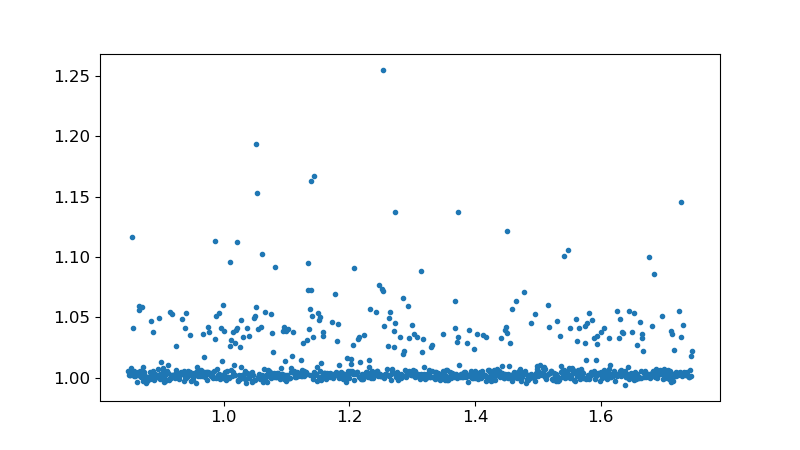

<ipython-input-27-eceed62dd4d3>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(new_w, new_f_array_1[0,:] / new_f_array_2[0,:], '.')
<ipython-input-27-eceed62dd4d3>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(new_w, new_f_array_1[0,:] / new_f_array_2[0,:], '.')


In [27]:
plt.figure()
plt.plot(new_w, new_f_array_1[0,:] / new_f_array_2[0,:], '.')
#plt.plot(new_w, new_f_array_2[0,:], '.')
plt.show()


<IPython.core.display.Javascript object>


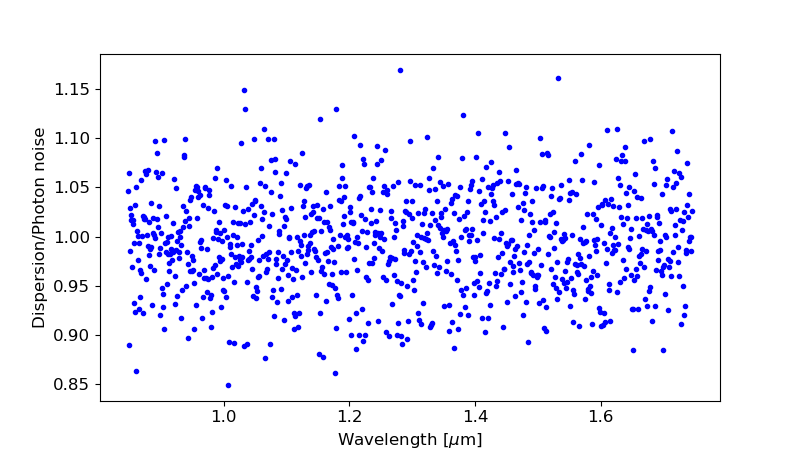

In [28]:
# Plot ratio between dispersion and photon noise vs wavelength
plt.figure()
plt.plot(new_w, ratio, '.', color='b')
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel('Dispersion/Photon noise')
plt.show()

In [29]:
# Relative difference
relatDiff_white = box_kim.relative_difference(f_white_2, f_white_1)

<IPython.core.display.Javascript object>


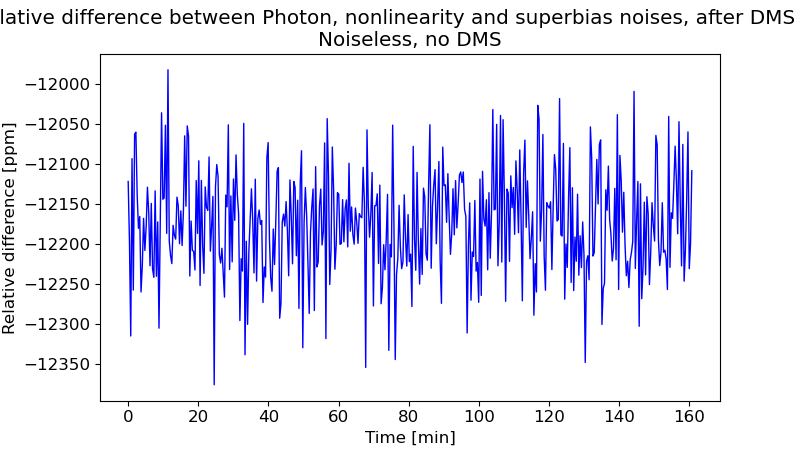

In [30]:
plt.figure()
plt.plot(time_min, relatDiff_white * 1e6, color='b')
plt.xlabel('Time [min]')
plt.ylabel(r'Relative difference [ppm]')
plt.title('Relative difference between {} and \n{}'.format(simulation_2, simulation_1))
plt.show()